<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/4logP_SMILEVAE_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [ ]:
# 10 tricks for a better Google Colab experience
# https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82
# %load_ext google.colab.data_table

In [1]:
!sudo apt-get install software-properties-common
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install gcc-4.9
!sudo apt-get upgrade libstdc++6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:9 h

In [2]:
# !pip install keras==2.2.4
%tensorflow_version 1.x
import keras
import tensorflow as tf
print("Keras: %s"%keras.__version__)
print("Tensorflow: %s"%tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.


Keras: 2.3.1
Tensorflow: 1.15.2


In [3]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2021-01-06 13:19:29--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2021-01-06 13:19:29--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | failed with initial froz

In [ ]:
# !strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX

In [4]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# FOR VAE Architecture 
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
print("RDKit: %s"%rdkit.__version__)
# Checking if GPU is enabled or not
tf.test.gpu_device_name()



RDKit: 2020.09.3


'/device:GPU:0'

# **Data Fetching**

In [5]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')
WEIGHTS_FOLDER = 'sample_data/weights/'
import csv
smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/SMILEWithProp.csv'      #"sample_data/SMILEWithoutProp.csv"
data = pd.read_csv(smifile, delimiter = ",", header='infer', encoding='utf-8')
# smifile ='/drive/My Drive/ZINC/Data/ZINC_Data/AAAA.smi'      
# data = pd.read_csv(smifile, delimiter = " ", header='infer', encoding='utf-8')
data.smiles = data.smiles.replace('\n','', regex=True)
NUM_SMILES = len(data)
data.head()

Mounted at /drive


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [6]:
# print(type(data.smiles.items))
# data= data[data['smiles'].str.len()<60]
# print(data.smiles.count())
print(len(data))

8179


In [7]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data, test_size=0.2, shuffle=False)
print("Training data shape", smiles_train.shape)
print("Testing Data shape", smiles_test.shape)
print(NUM_SMILES)

Training data shape (6543, 4)
Testing Data shape (1636, 4)
8179


In [10]:
logP_train = smiles_train['logP']
logP_test = smiles_test['logP']

# qed_train=smiles_train['qed']
# qed_test=smiles_test['qed']

# SAS_train=smiles_train['SAS']
# SAS_test=smiles_test['SAS']

train=np.array([logP_train])   #logP_train, qed_train, SAS_train
test= np.array([logP_test])             #logP_test, qed_test, SAS_test
y_train_property=train.transpose()
y_test_property=test.transpose()

In [11]:
#Labels for the Smiles String. We will deal with three properties values.
print(type(y_train_property))
print(type(y_test_property))
print("Training Data Property shape", y_train_property.shape)
print("Testing Data Property Shape", y_test_property.shape)
print(qed_train[1])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Training Data Property shape (6543, 1)
Testing Data Property Shape (1636, 1)
0.928975488089


### **Vector Representation of Data**

In [12]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
# print(char_to_int)
print(int_to_char)
print(len(charset), embed)
# print(embed)

{0: '@', 1: 'I', 2: '3', 3: ']', 4: 'o', 5: '=', 6: '\\', 7: 'C', 8: '-', 9: '[', 10: 'l', 11: 's', 12: '!', 13: 'r', 14: 'F', 15: 'H', 16: 'P', 17: '1', 18: 'n', 19: '2', 20: 'E', 21: '(', 22: 'N', 23: 'c', 24: '#', 25: '+', 26: '5', 27: '6', 28: '/', 29: 'S', 30: ')', 31: 'B', 32: '4', 33: 'O', 34: '7'}
35 107


In [13]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        # print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train['smiles'].values)
X_test = vectorize(smiles_test['smiles'].values)
print(X_train.shape)
print(X_test.shape)

(6543, 107, 35)
(1636, 107, 35)


### **Checking if Vectorization works!!**

56
O=C1c2ccccc2C(=O)N1N=Cc1ccc(/C=N/N2C(=O)c3ccccc3C2=O)cc1


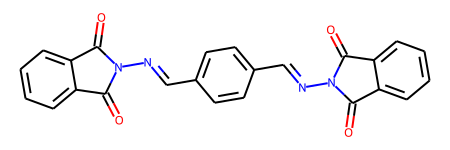

In [15]:
idx=2000
print(len(smiles_train['smiles'][idx]))
print(smiles_train['smiles'][idx])
mol = Chem.MolFromSmiles(smiles_train['smiles'][idx])
mol

56
O=C1c2ccccc2C(=O)N1N=Cc1ccc(/C=N/N2C(=O)c3ccccc3C2=O)cc1


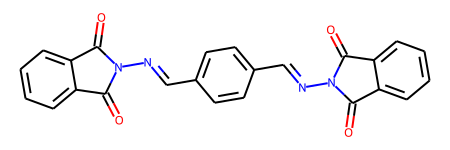

In [16]:
# Going back from vectorized form back to a readable string
smi="".join([int_to_char[idx] for idx in np.argmax(X_train[idx,:,:], axis=1)])
# String After Tructation of extra symbols
smi = re.sub('[!E]', '', smi)
print(len(smi))
print(smi)
mol = Chem.MolFromSmiles(smi)
mol

In [17]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
# print(mol_size_x)
# print(mol_size_y)
print(orig_dim)
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
# print(type(X_train))
# print(X_train.shape)
# print(X_train.shape[1])

3745


# **VAE**

In [18]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=20# Dimension of the latent vector (z)
epochs=50
pre_trained=False

### **Encoder**

In [19]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu', name='hidden')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer in the model
  encoder_output = Lambda(sampling, output_shape=(2,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output, name='encoder')



### **Decoder**

In [20]:
# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu', name='hidden')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid', name='decoder_lastlayer')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name='decoder')




### **Predictor**

In [21]:
def create_predictor_linear():
    '''
    Creates a regressor that estimates property values 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(Z_DIM,), name='predictor_input', dtype='float32')
    
    x = layers.Dense(10, activation='relu', name='hidden')(predictor_input)
    x = layers.Dense(1, activation='linear', name='predictor_lastlayer', dtype='float32')(x)
    return Model(predictor_input, x, name='predictor')


### **Creating the OverAll Model**

In [22]:
# Model Creation 
def create_model():

  #Creating Encoder
  vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,                                                                                         output_dim = Z_DIM)
# vae_encoder.summary()
  
  
  #Creating Decoder
  vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
# vae_decoder.summary()

  #Creating the Predictor
  predictor = create_predictor_linear()
  t_predicted = predictor(mean_mu)
  


  #Creating the VAE Model 
  vae_input = vae_encoder_input

  # Output will be the output of the decoder. The term - decoder(encoder_output) 
  vae_output = vae_decoder(vae_encoder_output)

  # # VAE Model with Predictor
  vae_predictor = Model(vae_input, [vae_output,t_predicted], name='VAE_with_Predictor')
# VAE Model without Property Predictor
  # vae_with_predictor = Model(vae_input, vae_output, name='VAE_without_Predictor')



  return vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder, vae_decoder_input, vae_decoder_output, vae_decoder,predictor, vae_input, vae_output, vae_predictor

#Creating the overall Model
encoder_input, encoder_output,  mean_mu, log_var, encoder, decoder_input, decoder_output, decoder, predictor, vae_input, vae_output, vae_predictor = create_model()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### **VAE Loss Function**

In [23]:
#VAE Loss Function
def vae_loss(vae_input, vae_output):
  reconstruction_loss = binary_crossentropy(vae_input, vae_output)
  reconstruction_loss = reconstruction_loss * orig_dim
    
  kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
  kl_loss = K.sum(kl_loss, axis=-1)    
  kl_loss = kl_loss * -0.5
  kl_weight=0.5
  reconst_weight=0.5
    
  # vae_loss_val = K.mean(reconstruction_loss + kl_loss)
  vae_loss_val=kl_weight * kl_loss + reconst_weight * reconstruction_loss
  return vae_loss_val


**Plotting all models**

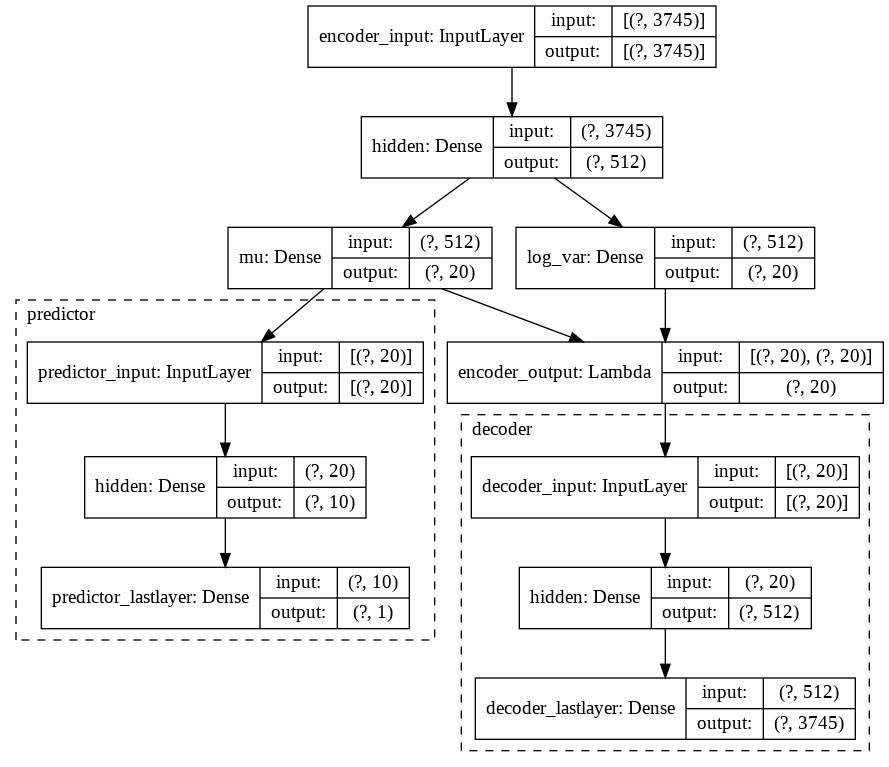

In [24]:
# Plot the Encoder Model
plot_model(encoder, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/only_encoder.png', show_shapes=True, show_layer_names=True)  #, expand_nested=True

# Plot the Decoder Model
plot_model(decoder, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/only_decoder.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# #Plot the Predictor Model
plot_model(predictor, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/only_predictor.png', show_shapes=True, show_layer_names=True)    #, expand_nested=True

# Plot the VAE-Predictor Model
plot_model(vae_predictor, to_file='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/smilesvae_with_logPpredictor.png', show_shapes=True, show_layer_names=True, expand_nested=True)   #, expand_nested=False



**Checkpoint**

In [26]:
# Creating Model Checkpoint for training...

checkpoint_path = "/drive/My Drive/ZINC/Models/OnlylogP/Weights/train_ckpt/cp.ckpt"
new_check_path="/drive/My Drive/ZINC/Models/OnlylogP/Weights/VAE_With_QEDPredictor{epoch:02d}-{val_loss:.2f}.h5"           #'VAE_Predictor{epoch:02d}.h5'
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=new_check_path, verbose=1, save_weights_only=False, save_best_only=True)   #, save_freq=5

# Loading weights from the latest checkpoints
#get the latest checkpoint file
checkpoint_dir = os.path.dirname(new_check_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

### **Training or Loading the VAE Model**

In [27]:
pre_trained=False
epochs=100
if __name__ == '__main__':          
#     Train the Variational AutoEncoder
    if pre_trained==False:
      vae_predictor.compile(optimizer='adam', 
                      loss=[vae_loss, 'mean_squared_error'], 
                      loss_weights=[3.0, 1.0]     
                      ) 
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback] )  
      vae_predictor.save(new_check_path)
    else:
      vae_predictor.load_weights(new_check_path)
      history = vae_predictor.fit(x=X_train,
                            y=[X_train,y_train_property], 
                            epochs=epochs,
                            validation_data=(X_test, [X_test, y_test_property]),
                            verbose=2,
                            callbacks=[cp_callback]) 
      vae_predictor.save(new_check_path)
    

Train on 6543 samples, validate on 1636 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 277.66859, saving model to /drive/My Drive/ZINC/Models/OnlylogP/Weights/VAE_With_QEDPredictor01-277.67.h5
6543/6543 - 3s - loss: 441.8442 - decoder_loss: 146.3978 - predictor_loss: 2.2828 - val_loss: 277.6686 - val_decoder_loss: 91.8915 - val_predictor_loss: 1.9185
Epoch 2/100

Epoch 00002: val_loss improved from 277.66859 to 259.18058, saving model to /drive/My Drive/ZINC/Models/OnlylogP/Weights/VAE_With_QEDPredictor02-259.18.h5
6543/6543 - 1s - loss: 266.3944 - decoder_loss: 88.2421 - predictor_loss: 1.6658 - val_loss: 259.1806 - val_decoder_loss: 85.7789 - val_predictor_loss: 1.4639
Epoch 3/100

Epoch 00003: val_loss improved from 259.18058 to 244.57910, saving model to /drive/My Drive/ZINC/Models/OnlylogP/Weights/VAE_With_QEDPredictor03-244.58.h5
6543/6543 - 1s - loss: 250.2207 - decoder_loss: 82.9235 - predictor_loss: 1.3504 - val_loss: 244.5791 - val_decoder_loss: 81.2332 - val

In [ ]:
# print(type(history))
# print(type(history.history))
print(history.history.keys())

dict_keys(['loss', 'decoder_loss', 'predictor_loss', 'val_loss', 'val_decoder_loss', 'val_predictor_loss'])


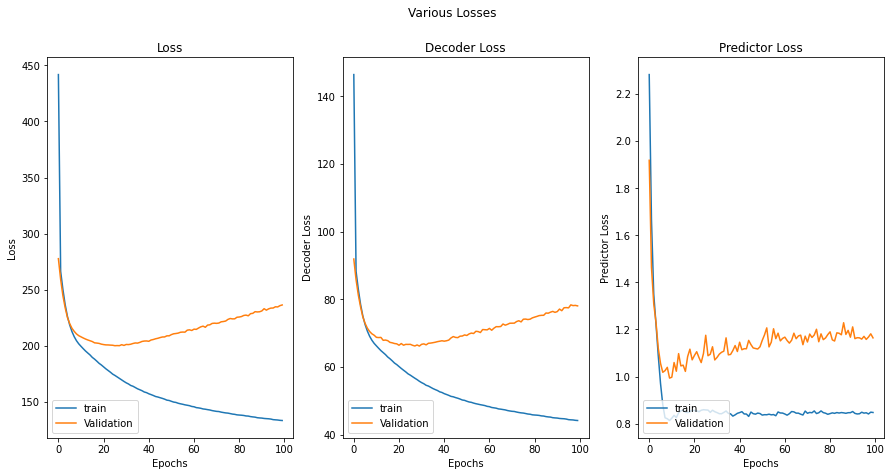

In [28]:
# summarize history for loss
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Various Losses')


ax1.plot(history.history['loss'])
ax1.plot( history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'Validation'], loc='lower left')


ax2.plot(history.history['decoder_loss'])
ax2.plot(history.history['val_decoder_loss'])
ax2.set_title('Decoder Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Decoder Loss')
ax2.legend(['train', 'Validation'], loc='lower left')

ax3.plot(history.history['predictor_loss']) 
ax3.plot(history.history['val_predictor_loss'])
ax3.set_title('Predictor Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Predictor Loss')
ax3.legend(['train', 'Validation'], loc='lower left')

# **Latent Space Visualization**

### **Each Component of latent space**

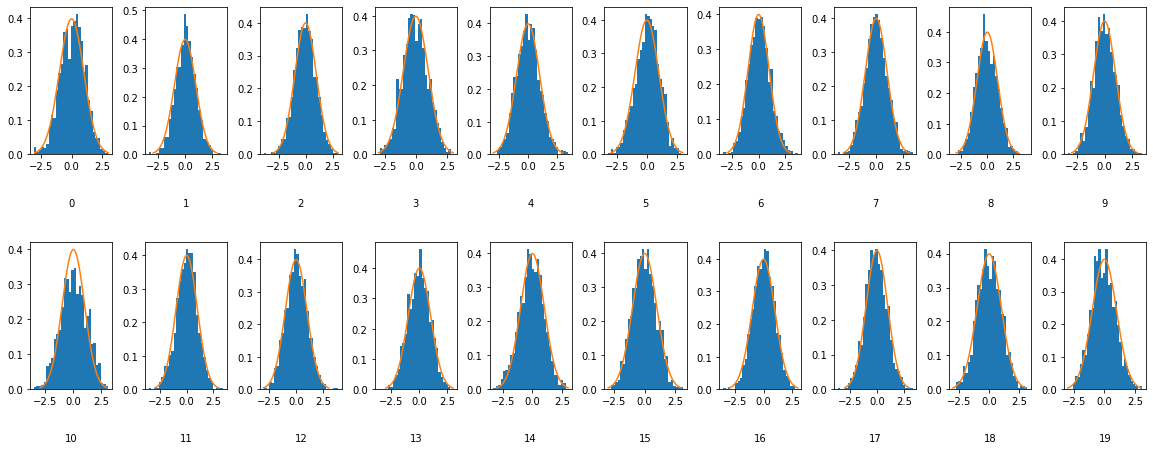

In [29]:
from scipy.stats import norm
# with graph.as_default():   # We are using this statement to reuse the last saved trained model
z_test = encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 30)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

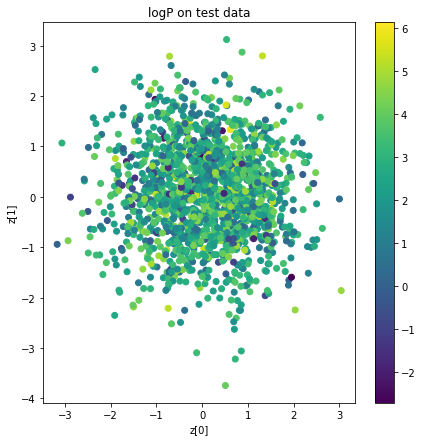

In [32]:
from sklearn.manifold import TSNE
z_mean = encoder.predict(X_test)
# print(z_mean)
model_name='/drive/My Drive/ZINC/Models/OnlylogP/Diagram/'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "VAESMILES_logPLatent_mean.png")

# z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=logP_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('logP on test data')
plt.savefig(filename)
plt.show()

# **Reconstruction**


In [33]:
# encoded, decoded and predicted data on test dataset

encoded_xtest=encoder.predict(X_test)
# predicted_xtest=predictor.predict(encoded_xtest)
decoded_xtest=decoder.predict(encoded_xtest)
print("Encoded data shape",encoded_xtest.shape)
# print("Predicted Property Data Shape",predicted_xtest.shape)
print("Reconstructed Test data Shape", decoded_xtest.shape)

# Reshaping the original and reconstructed test data
orig_test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
reconst_test = decoded_xtest.reshape(len(X_test), mol_size_x,mol_size_y)
print("Original Test Data Dimension",orig_test.shape)
print("Reconstructed Test Data Dimension", reconst_test.shape)

Encoded data shape (1636, 20)
Reconstructed Test data Shape (1636, 3745)
Original Test Data Dimension (1636, 107, 35)
Reconstructed Test Data Dimension (1636, 107, 35)


### **Reconstruction Original test data set**

1636 Original Valid Test Samples
4 Reconstructed Valid Test Samples
Molecule 92 Original Valid COC(=O)[C@H]1CC(=O)OC12CCCCC2
Molecule 92 Reconstructed Valid COC(=O)[C@H]1NC(=O)NCCCC(C)C1
Molecule 614 Original Valid C[C@@H](Oc1ccccc1C#N)C(=O)NCC1CCCCC1
Molecule 614 Reconstructed Valid C[C@@H](Cc1cccccccc11C(=O)N1C)CCCCC
Molecule 880 Original Valid CC[C@@](C)(CO)NC(=O)c1csc(I)c1
Molecule 880 Reconstructed Valid CC[C@@](C)(N)CNC(=O)c1ccc(C)C1F
Molecule 1353 Original Valid Cc1ccc([C@H](C)NC(=O)C[C@H]2C=CCC2)cc1F
Molecule 1353 Reconstructed Valid Cc1ccc([C@H](C)NC(=O)N[C@H](CC)CCO)cc1


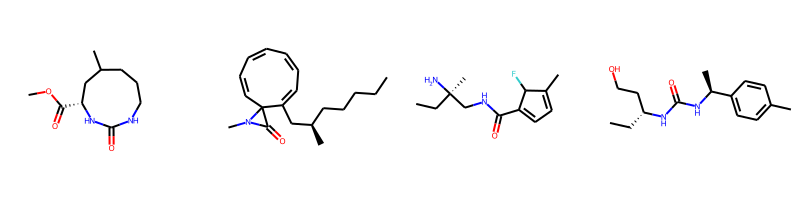

In [34]:
# Going back from vectorized form back to a readable string on original test data
IPythonConsole.ipython_useSVG=True 
mols_orig_test= []
smi_orig_test=[]
syntax_val={0:[], 1:[]}

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_orig_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid SMiles" ,sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
      # print(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 


smi_orig_test_valid=[]
mols_orig_test_valid=[]
for item in syntax_val[1]:
  smi_orig_test_valid.append(smi_orig_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
# smi_orig_test_valid


print(len(mols_orig_test_valid), "Original Valid Test Samples")
# Draw.MolsToGridImage(mols_orig_test_valid, molsPerRow=4,subImgSize=(200,200))



### **Reconstruction on reconstructed test data**

from rdkit import RDLogger  
# Going back from vectorized form back to a readable string on original test data
#Reconstruction
syntax_val={0:[], 1:[]}
mols_reconst_test= []
smi_reconst_test=[]

RDLogger.DisableLog('rdApp.*')  

for id in range(len(X_test)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_test[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_test.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_test.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Reconstructed Smile", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=False)
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue


smi_reconst_test_valid=[]
mols_reconst_test_valid=[]
smi_orig_test_valid=[]
mols_orig_test_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Test Samples")
for item in syntax_val[1]:
  smi_reconst_test_valid.append(smi_reconst_test[item])
  smi_orig_test_valid.append(smi_orig_test[item])

  mols_reconst_test_valid.append(mols_reconst_test[item])
  mols_orig_test_valid.append(mols_orig_test[item])
  print("Molecule", item, "Original Valid", smi_orig_test[item] )
  print("Molecule", item, "Reconstructed Valid", smi_reconst_test[item])

Draw.MolsToGridImage(mols_reconst_test_valid, molsPerRow=4,subImgSize=(200,200))



## **Reconstruction on Training data**

6543 Original Valid Training Samples
53 Reconstructed Valid Training Samples
Molecule 41 Original Valid O=C(CCCO)Nc1ccc(F)cc1F
Molecule 41 Reconstructed valid O=C(CCCO)Nc1ccc(F)cc1F
Molecule 237 Original Valid Cc1cc(Br)ccc1CNC(=O)C1CC=CC1
Molecule 237 Reconstructed valid Cc1cc(Br)ccc1CNC(=O)C1CCnC1C
Molecule 421 Original Valid C/C=C/C=C/C(=O)N1C[C@@H](C(=O)OC)[C@@H](C)C1
Molecule 421 Reconstructed valid C/CNC/CCC/C(=C)CCC[C@@H](CC=O)NCC[N@@](C)CCC
Molecule 469 Original Valid COc1ccc(C(=O)OCc2nc3ccccc3s2)cn1
Molecule 469 Reconstructed valid COc1ccc(C(=O)OSc2nccccccccs2)cn1
Molecule 516 Original Valid CCc1nnc(NC(=O)c2ccccc2N)s1
Molecule 516 Reconstructed valid CCc1ncc(NC(=O)c2ccccc2N)s1
Molecule 926 Original Valid C[C@H](OC(=O)c1ccc2ccccc2n1)C(=O)NCC1CCCCC1
Molecule 926 Reconstructed valid C[C@H](CC(=O)c1ccccccccc1n1)C(=O)N(C)CCCCCc1
Molecule 1122 Original Valid Cc1ccc(F)c(Br)n1
Molecule 1122 Reconstructed valid Cc1ccc(F)c(Br)n1
Molecule 1168 Original Valid Cn1ncnc1NC(=O)NCCCC[NH+]1CCCC1

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


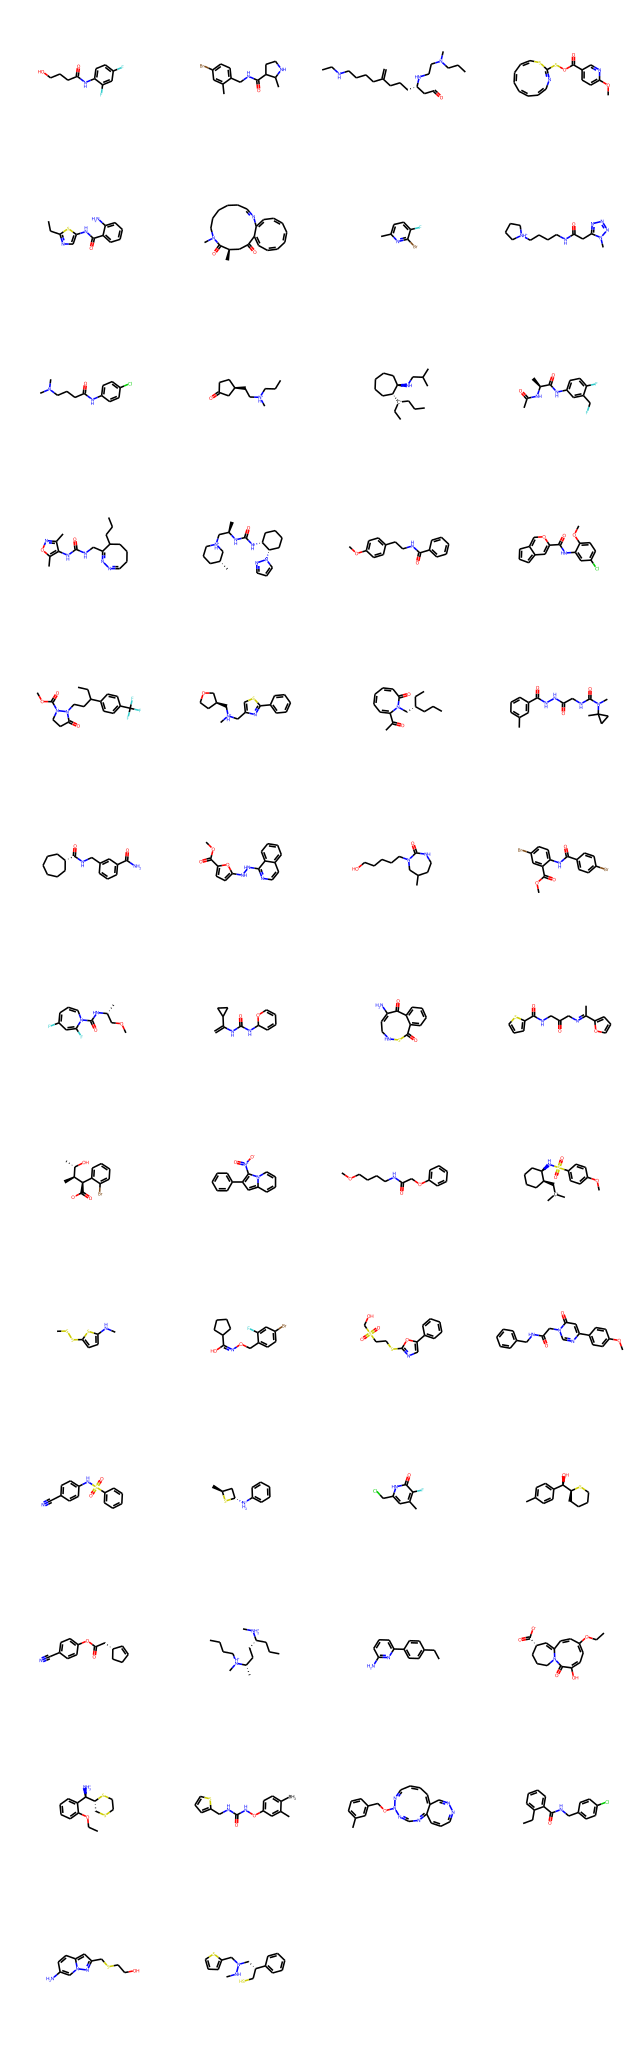

In [35]:
# encoded, decoded and predicted data on Training dataset

encoded_xtrain=encoder.predict(X_train)
# predicted_xtest=predictor.predict(encoded_xtrain)
decoded_xtrain=decoder.predict(encoded_xtrain)
# print(encoded_xtrain.shape)
# print(predicted_xtrain.shape)
# print(decoded_xtrain.shape)

# Reshaping the original and reconstructed train data
orig_train=X_train.reshape(len(X_train), mol_size_x, mol_size_y)
reconst_train = decoded_xtrain.reshape(len(X_train), mol_size_x,mol_size_y)
# print(orig_train.shape)
# print(reconst_train.shape)
# Going back from vectorized form back to a readable string on original training data

syntax_val={0:[], 1:[]}

smi_orig_train=[]
mols_orig_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(orig_train[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_orig_train.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_orig_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(mol), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)
    except:
      print('Mol {} {}'.format(id+1, mol)) 

smi_orig_train_valid=[]
mols_orig_train_valid=[]

for item in syntax_val[1]:
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))
  mols_orig_train_valid.append(mols_orig_train[item])


print(len(mols_orig_train_valid), "Original Valid Training Samples")
# Draw.MolsToGridImage(mols_orig_train_valid, molsPerRow=4,subImgSize=(200,200))

# Going back from vectorized form back to a readable string on Reconstructed training data
#Reconstruction

syntax_val={0:[], 1:[]}

smi_reconst_train=[]
mols_reconst_train= []

for id in range(len(X_train)):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_train[id,:,:], axis=1)])
  # print(len(mol))
  smi = re.sub('!|E',"", smi)
  smi_reconst_train.append(smi)
  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_train.append(mol)
  if mol is None:
    syntax_val[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol, kekulize=True)      
    except:
      # print('Mol {} {}'.format(id+1, mol)) 
      continue

smi_reconst_train_valid=[]
mols_reconst_train_valid=[]
smi_orig_train_valid=[]
mols_orig_train_valid=[]

print(len(syntax_val[1]), "Reconstructed Valid Training Samples")
for item in syntax_val[1]:
  smi_reconst_train_valid.append(smi_reconst_train[item].rstrip('\n'))
  smi_orig_train_valid.append(smi_orig_train[item].rstrip('\n'))

  mols_reconst_train_valid.append(mols_reconst_train[item])
  mols_orig_train_valid.append(mols_orig_train[item])

  print("Molecule", item,"Original Valid", smi_orig_train[item])
  print("Molecule" , item, "Reconstructed valid", smi_reconst_train[item])


Draw.MolsToGridImage(mols_reconst_train_valid, molsPerRow=4,subImgSize=(200,200))



In [36]:
print("Validity Percentage of Training Reconstructed Molecules", (len(mols_reconst_train_valid)/len(mols_reconst_train))*100, "%")
print("Validity Percentage of Testing Reconstructed Molecules", (len(mols_reconst_test_valid)/len(mols_reconst_test))*100,"%")

Validity Percentage of Training Reconstructed Molecules 0.8100259819654593 %
Validity Percentage of Testing Reconstructed Molecules 0.24449877750611246 %


# **Generating New Valid Molecules from Normal Distribution**

New valid Molecule 1 CCCCC=C1CCC(=O)NC[C@@H](CCCCC[CH+](CC(C)))c1 Index= 156
New valid Molecule 2 CNCCCOc1ccc(NC(=O)NCCC)CC(=O)c2ccccc2cc1C Index= 4798
New valid Molecule 3 Cc1cc(NC(=O)CCC(=O)NC2cc(F)ccc22)cc21 Index= 4865
New valid Molecule 4 O=C(NCCccccccc1cc11)N/CCccccccccc1 Index= 6474
New valid Molecule 5 C=CCCC(=O)N1C[C@@H](CCCCO)Ccccccc1 Index= 7766
5 New Valid Molecules


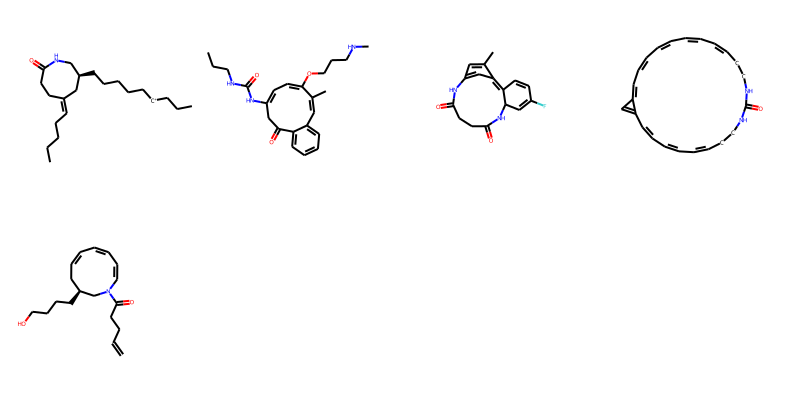

In [38]:
syntax_val_new={0:[], 1:[]}


smi_reconst_new=[]
smi_reconst_new_valid=[]

mols_reconst_new= []
mols_reconst_new_valid=[]

n_mol=10000

latent_samples= np.random.normal(0,1,size=(n_mol,Z_DIM))

#Passing it to Decoder
reconst_sample = decoder.predict(latent_samples)
reconst_smi=reconst_sample.reshape(n_mol, mol_size_x, mol_size_y) 

for id, latent_mol in enumerate(reconst_smi):
  smi="".join([int_to_char[idx] for idx in np.argmax(reconst_smi[id,:,:], axis=1)])
  smi = re.sub('!|E',"", smi)
  smi_reconst_new.append(smi)

  mol = Chem.MolFromSmiles(smi, sanitize=True)
  mols_reconst_new.append(mol)
  if mol is None:
    syntax_val_new[0].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t invalid SMILES", sep=' ')
    # print(mol, end ='\n', sep= ' ')
    continue
  else:
    syntax_val_new[1].append(id)
    # print('Mol', id+1, "\t length =",len(smi), "\t",  smi, "\t Valid New Smiles", sep=' ', end ='\n', flush = True)
    try:
      Chem.SanitizeMol(mol)      
    except:
      print('Mol {} {}'.format(id+1, mol)) 

i=1
for item in syntax_val_new[1]:
  smi_reconst_new_valid.append(smi_reconst_new[item].rstrip('\n'))
  mols_reconst_new_valid.append(mols_reconst_new[item])
  print("New valid Molecule", i, smi_reconst_new[item], "Index=", item)
  i=i+1

print(len(mols_reconst_new_valid), "New Valid Molecules")
Draw.MolsToGridImage(mols_reconst_new_valid, molsPerRow=4,subImgSize=(200,200))


# **Property Acceptance of Newly Generated Valid Molecules**

In [40]:
# Calculating mean and standard deviation of all property values on test data

logP_mean_test= np.mean(y_test_property, axis=0)
logP_std_test = np.std(y_test_property, axis=0)
print("Mean of logP Property Value", logP_mean_test)
print("Standard Deviation of logP Property Value", logP_std_test)

# Predicting Properties of New Valid Molecules

predicted_prop_samples=predictor.predict(latent_samples[syntax_val_new[1]])


for ((id,item), val_mol_id) in zip(enumerate(predicted_prop_samples), syntax_val_new[1]):
  # print(id)
  e=predicted_prop_samples[id][0]<(logP_mean_test+logP_std_test)
  f=predicted_prop_samples[id][0]>=(logP_mean_test-logP_std_test)
  print("Predicted Property of molecule having index ", val_mol_id,"is", predicted_prop_samples[id][0])
  if (e & f):
    print("Mol {}, Property Validated".format(val_mol_id))    
  else:    
    print("Mol {}, Property Invalidated".format(val_mol_id))  
  

Mean of logP Property Value [2.48842016]
Standard Deviation of logP Property Value [1.44255801]
Predicted Property of molecule having index  156 is -0.16985404
Mol 156, Property Invalidated
Predicted Property of molecule having index  4798 is 3.251413
Mol 4798, Property Validated
Predicted Property of molecule having index  4865 is 2.8614228
Mol 4865, Property Validated
Predicted Property of molecule having index  6474 is 3.5191674
Mol 6474, Property Validated
Predicted Property of molecule having index  7766 is 1.653311
Mol 7766, Property Validated


In [ ]:
# print(syntax_val_new[1])
# print(predicted_prop_samples.shape)
# print(predicted_prop_samples)
# print(type(predicted_prop_samples))
